Class Distribution:
label
melanocytic nevi                 6705
melanoma                         1112
benign keratosis-like lesions    1098
basal cell carcinoma              514
actinic keratoses                 327
vascular lesions                  142
dermatofibroma                    115
Name: count, dtype: int64


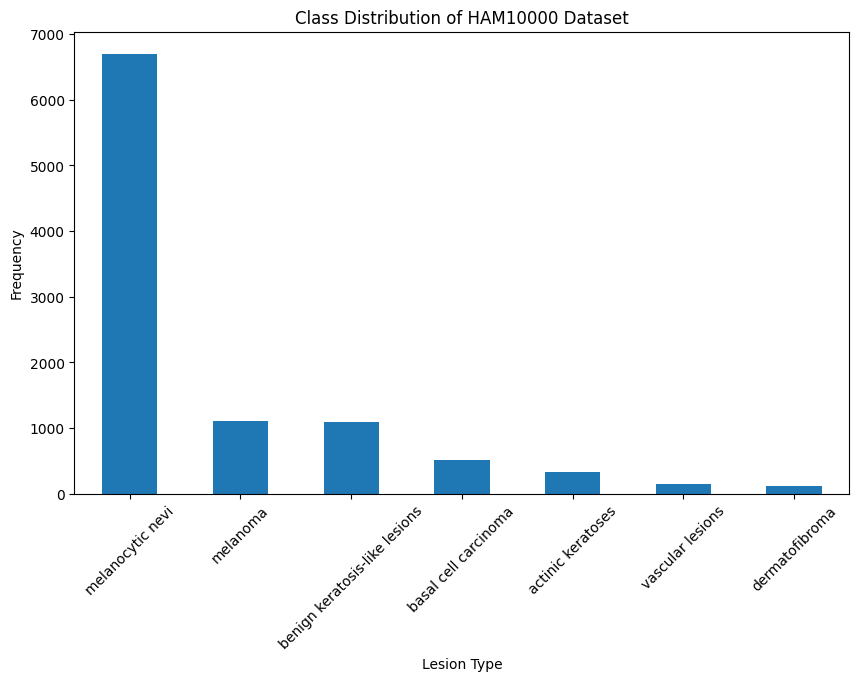


Images have been successfully copied to subfolders in: /kaggle/working/output_images/


In [ ]:
import os
import json
import shutil
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Define Paths ---
base_dir = '/kaggle/input/skin-cancer-ham10000/'  

# Sub-directories for images and annotations
image_dir = os.path.join(base_dir, 'ds', 'img')
ann_dir = os.path.join(base_dir, 'ds', 'ann')

output_dir = '/kaggle/working/output_images/'

# --- 2. Perform EDA ---
# Get a list of all annotation files
ann_files = [f for f in os.listdir(ann_dir) if f.endswith('.json')]

# Use a Counter to store the frequency of each class
class_counts = Counter()
# A list to store data for a DataFrame
eda_data = []

# Loop through each annotation file
for ann_file in ann_files:
    with open(os.path.join(ann_dir, ann_file)) as f:
        ann_data = json.load(f)
        # The label is in 'classTitle' within the 'objects' list
        if ann_data.get('objects'):
            label = ann_data['objects'][0].get('classTitle')
            if label:
                class_counts[label] += 1
                # Use the .jpg extension for the image file
                image_filename = ann_file.replace('.jpg.json', '.jpg')
                eda_data.append({'image_id': image_filename, 'label': label})


# Create a DataFrame from the collected data
df = pd.DataFrame(eda_data)

# Print the class distribution
print("Class Distribution:")
print(df['label'].value_counts())


# --- 3. Visualize the Class Distribution ---
plt.figure(figsize=(10, 6))
df['label'].value_counts().plot(kind='bar')
plt.title('Class Distribution of HAM10000 Dataset')
plt.xlabel('Lesion Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


# --- 4. Create Subfolders and Copy Images ---
os.makedirs(output_dir, exist_ok=True)

# Create a subfolder for each unique class label
for label in df['label'].unique():
    # Sanitize label name for folder creation if necessary
    safe_label = label.replace(" ", "_").replace("/", "_")
    os.makedirs(os.path.join(output_dir, safe_label), exist_ok=True)

# Copy each image to its corresponding class folder
for index, row in df.iterrows():
    image_filename = row['image_id']
    label = row['label']
    safe_label = label.replace(" ", "_").replace("/", "_")
    
    # Define the source and destination paths for the image
    source_path = os.path.join(image_dir, image_filename)
    destination_path = os.path.join(output_dir, safe_label, image_filename)
    

    if os.path.exists(source_path):
        shutil.copy(source_path, destination_path)
    else:
        print(f"Warning: Source file not found {source_path}")


print(f"\nImages have been successfully copied to subfolders in: {output_dir}")

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
import pandas as pd 

# --- 1. Define Paths and Basic Parameters ---
output_dir = '/kaggle/working/output_images/'
BATCH_SIZE = 32
IMG_SIZE = 224 # A common size for pretrained models 

# --- 2. Define Transforms ---

# Augmentations for the training set
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Standard for ImageNet models
])

# For the validation/test set, we only want to resize and normalize
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- 3. Create Datasets --
# PyTorch's ImageFolder is utilized, as it automatically finds classes from folder names.
full_dataset = ImageFolder(output_dir, transform=train_transforms)


# --- 4. Address Class Imbalance with WeightedRandomSampler ---

# Get the class distribution from the dataset object
class_counts = np.bincount(full_dataset.targets)
print(f"Original Class Counts: {class_counts}")

# Calculate weights for each class (inverse of frequency)
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
print(f"Class Weights: {class_weights}")

# Assign a weight to each sample in the dataset
# The weights list must have the same size as the dataset (one weight per sample)
sample_weights = np.array([class_weights[t] for t in full_dataset.targets])
sample_weights = torch.from_numpy(sample_weights)

# Create the WeightedRandomSampler
# This sampler will draw samples with probabilities proportional to their weights.
# It ensures that each batch has a more balanced representation of classes.
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)


# --- 5. Create DataLoaders ---

# Unbalanced DataLoader (for validation)
# The validation loader should NOT use the sampler, as we want to evaluate on the true distribution.
unbalanced_loader = DataLoader(
    full_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True 
)

# Balanced DataLoader (for training)
# This is the one you should use to train your model.
balanced_loader = DataLoader(
    full_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    # Note: 'shuffle' must be False when using a sampler
)

print(f"\nCreated two DataLoaders:")
print("- 'balanced_loader': For training. It uses a WeightedRandomSampler to fight class imbalance.")
print("- 'unbalanced_loader': For validation/testing or for comparison.")

# --- Inspect a batch from the balanced loader ---
print("\nInspecting a batch from the balanced_loader to check class distribution:")
for i, (images, labels) in enumerate(balanced_loader):
    print(f"Batch {i+1} label distribution:")
    print(torch.bincount(labels, minlength=len(class_counts)))
    if i == 2: # Inspect first 3 batches
        break

Original Class Counts: [ 327  514 1098  115 6705 1112  142]
Class Weights: tensor([0.0031, 0.0019, 0.0009, 0.0087, 0.0001, 0.0009, 0.0070])

Created two DataLoaders:
- 'balanced_loader': For training. It uses a WeightedRandomSampler to fight class imbalance.
- 'unbalanced_loader': For validation/testing or for comparison.

Inspecting a batch from the balanced_loader to check class distribution:
Batch 1 label distribution:
tensor([5, 2, 5, 7, 2, 6, 5])
Batch 2 label distribution:
tensor([9, 3, 5, 5, 5, 0, 5])
Batch 3 label distribution:
tensor([2, 1, 8, 3, 3, 8, 7])


In [ ]:
!pip install timm -q

In [ ]:
# --- 0. Install and Import Required Libraries ---
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, WeightedRandomSampler, random_split, Subset
import numpy as np
import timm
from tqdm.notebook import tqdm
import os

# --- 1. Define Configuration and Setup for Multi-GPU ---
# Check for multiple GPUs
num_gpus = torch.cuda.device_count()
print(f"Found {num_gpus} GPUs.")

# --- Key Change: Increased number of epochs ---
NUM_EPOCHS = 15

# Configuration from previous step
BATCH_SIZE_PER_GPU = 32
TOTAL_BATCH_SIZE = BATCH_SIZE_PER_GPU * num_gpus if num_gpus > 0 else 32
LEARNING_RATE = 0.001 * 2

IMG_SIZE = 224
NUM_CLASSES = 7
MODEL_NAME = 'seresnext101_32x8d'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Primary device: {device}")
print(f"Using model: {MODEL_NAME}")
print(f"Training for: {NUM_EPOCHS} epochs")
print(f"Total Batch Size: {TOTAL_BATCH_SIZE} ({BATCH_SIZE_PER_GPU} per GPU)")
print(f"Initial Learning Rate: {LEARNING_RATE}")


# --- 2. Define Data Augmentations (Transforms) ---
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(40),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- 3. Create Datasets and Split into Train/Validation ---
output_dir = '/kaggle/working/output_images/'
train_full_dataset = ImageFolder(output_dir, transform=train_transforms)
val_full_dataset = ImageFolder(output_dir, transform=val_transforms)

train_size = int(0.8 * len(train_full_dataset))
val_size = len(train_full_dataset) - train_size
train_indices, val_indices = random_split(range(len(train_full_dataset)), [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_dataset = Subset(train_full_dataset, train_indices.indices)
val_dataset = Subset(val_full_dataset, val_indices.indices)
print(f"\nData split into {len(train_dataset)} training and {len(val_dataset)} validation samples.")

# --- 4. Create Weighted Sampler for the TRAINING SET ---
train_targets = [train_full_dataset.targets[i] for i in train_indices.indices]
class_counts = np.bincount(train_targets)
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = np.array([class_weights[t] for t in train_targets])
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
print("WeightedRandomSampler created for the training set.")

# --- 5. Create Final DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=TOTAL_BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=TOTAL_BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# --- 6. Define and Wrap Model for Multi-GPU Training ---
model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=NUM_CLASSES)

if num_gpus > 1:
    print(f"\nWrapping model with nn.DataParallel for {num_gpus} GPUs.")
    model = nn.DataParallel(model)

model.to(device)

# --- 7. Define Loss Function, Optimizer, and Scheduler ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# --- 8. Training and Validation Loop ---
print("\nStarting training...")
best_val_acc = 0.0
history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'lr': []}

for epoch in range(NUM_EPOCHS):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Training]"):
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    history['train_loss'].append(train_loss)

    # --- Validation Phase ---
    model.eval()
    running_vloss = 0.0
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Validation]"):
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_vloss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    val_loss = running_vloss / len(val_loader)
    val_acc = 100 * correct_predictions / total_samples
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(scheduler.get_last_lr()[0])

    # Step the scheduler
    scheduler.step()
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} -> Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%, LR: {history['lr'][-1]:.6f}")

    # --- 9. Save the Best Model ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        print(f"New best validation accuracy: {val_acc:.2f}%. Saving model to 'best_model.pth'...")
        # Save the underlying model state_dict whether using DataParallel or not
        state_dict_to_save = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
        torch.save(state_dict_to_save, 'best_model.pth')

print(f"\nTraining finished. Best Validation Accuracy achieved: {best_val_acc:.2f}%")

In [ ]:
import torch
import torch.nn as nn
import timm
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split


# --- 1. Configuration ---
MODEL_NAME = 'seresnext101_32x8d'
NUM_CLASSES = 7
IMG_SIZE = 224
BATCH_SIZE = 64
output_dir = '/kaggle/working/output_images/'
best_model_path = 'best_model.pth'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# --- 2. Load the Validation Dataset ---
# We need to use the same validation split to get a fair evaluation.
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Re-create the exact same validation split using the same seed
full_dataset = ImageFolder(output_dir, transform=val_transforms)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
_, val_indices = random_split(range(len(full_dataset)), [train_size, val_size], generator=torch.Generator().manual_seed(42))
val_dataset = Subset(full_dataset, val_indices.indices)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
class_names = full_dataset.classes
print("Class Names:", class_names)


# --- 3. Load the Saved Model ---
# Initialize the model structure
model = timm.create_model(MODEL_NAME, pretrained=False, num_classes=NUM_CLASSES)

# Load the state dictionary
model.load_state_dict(torch.load(best_model_path))
model.to(device)
model.eval() # Set the model to evaluation mode

print(f"\nModel '{best_model_path}' loaded successfully and set to evaluation mode.")


# --- 4. Get Predictions ---
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- 5. Generate and Display Evaluation Metrics ---

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, WeightedRandomSampler, random_split, Subset
import numpy as np
import timm
from tqdm.notebook import tqdm
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
# --- CORRECTED IMPORT ---
from timm.loss import SoftTargetCrossEntropy

# --- 1. Define Configuration and Setup for Multi-GPU ---
num_gpus = torch.cuda.device_count()
print(f"Found {num_gpus} GPUs.")

NUM_EPOCHS = 15
BATCH_SIZE_PER_GPU = 32
TOTAL_BATCH_SIZE = BATCH_SIZE_PER_GPU * num_gpus if num_gpus > 0 else 32
LEARNING_RATE = 0.002
IMG_SIZE = 224
NUM_CLASSES = 7
MODEL_NAME = 'seresnext101_32x8d'

# Configuration for MixUp and CutMix
MIXUP_PROB = 1.0
MIXUP_ALPHA = 0.8
CUTMIX_ALPHA = 1.0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using advanced training script with MixUp/CutMix and Test-Time Augmentation.")


# --- 2. Define Data Augmentations (Transforms) ---
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- 3. Create Datasets and Split into Train/Validation ---
output_dir = '/kaggle/working/output_images/'
train_full_dataset = ImageFolder(output_dir, transform=train_transforms)
val_full_dataset = ImageFolder(output_dir, transform=val_transforms)

train_size = int(0.8 * len(train_full_dataset))
val_size = len(train_full_dataset) - train_size
train_indices, val_indices = random_split(range(len(train_full_dataset)), [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_dataset = Subset(train_full_dataset, train_indices.indices)
val_dataset = Subset(val_full_dataset, val_indices.indices)

# --- 4. Create Weighted Sampler for the TRAINING SET ---
train_targets = [train_full_dataset.targets[i] for i in train_indices.indices]
class_counts = np.bincount(train_targets)
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = np.array([class_weights[t] for t in train_targets])
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# --- 5. Create DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=TOTAL_BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=TOTAL_BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# --- 6. Define Model, MixUp, Loss, Optimizer, and Scheduler ---
model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=NUM_CLASSES)

if num_gpus > 1:
    model = nn.DataParallel(model)
model.to(device)

mixup_fn = timm.data.Mixup(
    mixup_alpha=MIXUP_ALPHA, cutmix_alpha=CUTMIX_ALPHA, prob=MIXUP_PROB,
    label_smoothing=0.1, num_classes=NUM_CLASSES
)

criterion = SoftTargetCrossEntropy().to(device)

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# --- 7. Training Loop ---
print("\nStarting training with MixUp/CutMix...")
best_val_acc = 0.0

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Training]"):
        images, labels = images.to(device), labels.to(device)
        images, mixed_labels = mixup_fn(images, labels)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, mixed_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    val_acc = 100 * correct / total
    scheduler.step()
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} -> Train Loss: {train_loss:.4f}, Standard Val Acc: {val_acc:.2f}%, LR: {scheduler.get_last_lr()[0]:.6f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        print(f"New best standard val acc: {val_acc:.2f}%. Saving model to 'best_model_advanced.pth'...")
        torch.save(model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict(), 'best_model_advanced.pth')

print(f"\nTraining finished. Best Standard Validation Accuracy: {best_val_acc:.2f}%")



In [ ]:
# --- 8. Final Evaluation with Test-Time Augmentation (TTA) ---
print("\n--- Starting Final Evaluation with Test-Time Augmentation ---")

# Load the best model weights
# Re-initialize the base model (without DataParallel)
best_model = timm.create_model(MODEL_NAME, pretrained=False, num_classes=NUM_CLASSES)
best_model.load_state_dict(torch.load('best_model_advanced.pth'))
best_model.to(device)
best_model.eval()

all_preds_tta = []
all_labels_tta = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="TTA Evaluation"):
        images, labels = images.to(device), labels.to(device)
        
        # Original prediction
        outputs_orig = best_model(images)
        probs_orig = F.softmax(outputs_orig, dim=1)
        
        # Horizontally-flipped prediction
        outputs_flip = best_model(torch.flip(images, dims=[3]))
        probs_flip = F.softmax(outputs_flip, dim=1)
        
        # Average the probabilities
        avg_probs = (probs_orig + probs_flip) / 2
        
        _, predicted = torch.max(avg_probs, 1)
        all_preds_tta.extend(predicted.cpu().numpy())
        all_labels_tta.extend(labels.cpu().numpy())

# --- 9. Display Final TTA-based Evaluation Metrics ---
class_names = train_full_dataset.classes
print("\nClassification Report (with TTA):")
print(classification_report(all_labels_tta, all_preds_tta, target_names=class_names, digits=4))

print("\nConfusion Matrix (with TTA):")
cm = confusion_matrix(all_labels_tta, all_preds_tta)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (with Test-Time Augmentation)')
plt.show()

tta_accuracy = 100 * np.sum(np.array(all_preds_tta) == np.array(all_labels_tta)) / len(all_labels_tta)
print(f"\nFinal Accuracy with TTA: {tta_accuracy:.2f}%")

In [ ]:
import torch
import torch.nn as nn
import timm
from torch.utils.data import DataLoader, Subset, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from tqdm.notebook import tqdm

# --- 1. Configuration ---
MODEL_NAME = 'seresnext101_32x8d'
NUM_CLASSES = 7
IMG_SIZE = 224
BATCH_SIZE = 64
output_dir = '/kaggle/working/output_images/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Paths to your two best models
model_a_path = 'best_model.pth' # The simpler, first model
model_b_path = 'best_model_advanced.pth' # The advanced MixUp/CutMix model

# --- 2. Load Validation Dataset (same as before) ---
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_dataset = ImageFolder(output_dir, transform=val_transforms)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
_, val_indices = random_split(range(len(full_dataset)), [train_size, val_size], generator=torch.Generator().manual_seed(42))
val_dataset = Subset(full_dataset, val_indices.indices)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
class_names = full_dataset.classes
print("Performing ensemble evaluation on the validation set.")

# --- 3. Load Both Models ---
model_a = timm.create_model(MODEL_NAME, pretrained=False, num_classes=NUM_CLASSES)
model_a.load_state_dict(torch.load(model_a_path))
model_a.to(device)
model_a.eval()
print(f"Model A ('{model_a_path}') loaded.")

model_b = timm.create_model(MODEL_NAME, pretrained=False, num_classes=NUM_CLASSES)
model_b.load_state_dict(torch.load(model_b_path))
model_b.to(device)
model_b.eval()
print(f"Model B ('{model_b_path}') loaded.")

# --- 4. Get Ensemble Predictions ---
all_preds_ensemble = []
all_labels_ensemble = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Ensemble Evaluation"):
        images, labels = images.to(device), labels.to(device)

        # Get probabilities from Model A
        outputs_a = model_a(images)
        probs_a = F.softmax(outputs_a, dim=1)

        # Get probabilities from Model B
        outputs_b = model_b(images)
        probs_b = F.softmax(outputs_b, dim=1)
        
        # Average the probabilities from both models
        avg_probs = (probs_a + probs_b) / 2
        
        _, predicted = torch.max(avg_probs, 1)
        all_preds_ensemble.extend(predicted.cpu().numpy())
        all_labels_ensemble.extend(labels.cpu().numpy())

# --- 5. Display Final Ensemble Metrics ---
print("\n--- Final Ensemble Performance ---")
print("\nClassification Report (Ensemble):")
print(classification_report(all_labels_ensemble, all_preds_ensemble, target_names=class_names, digits=4))

print("\nConfusion Matrix (Ensemble):")
cm = confusion_matrix(all_labels_ensemble, all_preds_ensemble)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Final Ensemble Confusion Matrix')
plt.show()

ensemble_accuracy = 100 * np.sum(np.array(all_preds_ensemble) == np.array(all_labels_ensemble)) / len(all_labels_ensemble)
print(f"\nFinal Ensemble Accuracy: {ensemble_accuracy:.2f}%")

In [ ]:
import torch
import torch.nn as nn
import timm
import torch.nn.functional as F

class EnsembleModel(nn.Module):
    def __init__(self, model_a, model_b):
        super(EnsembleModel, self).__init__()
        self.model_a = model_a
        self.model_b = model_b
        # Freeze the parameters of the sub-models
        for model in [self.model_a, self.model_b]:
            for param in model.parameters():
                param.requires_grad = False

    def forward(self, x):
        # Get predictions from both models
        outputs_a = self.model_a(x)
        outputs_b = self.model_b(x)

        # Convert to probabilities
        probs_a = F.softmax(outputs_a, dim=1)
        probs_b = F.softmax(outputs_b, dim=1)

        # Average the probabilities for the final prediction
        avg_probs = (probs_a + probs_b) / 2
        return avg_probs

# --- How to use it ---
# 1. Load your two individual models first
model_a = timm.create_model('seresnext101_32x8d', pretrained=False, num_classes=7)
model_a.load_state_dict(torch.load('best_model.pth'))
model_a.eval()

model_b = timm.create_model('seresnext101_32x8d', pretrained=False, num_classes=7)
model_b.load_state_dict(torch.load('best_model_advanced.pth'))
model_b.eval()

# 2. Create the ensemble
final_ensemble = EnsembleModel(model_a, model_b).to(device)


print("Ensemble model is ready for inference.")

In [4]:
torch.cuda.empty_cache()

In [ ]:
# --- 0. Install and Import Required Libraries ---
!pip install optuna -q
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torch.utils.data import DataLoader, Subset, random_split, WeightedRandomSampler
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from tqdm.notebook import tqdm
import gc
import numpy as np
from torch.cuda.amp import GradScaler, autocast

# --- 1. Configuration ---
TUNING_MODEL_NAME = 'seresnext50_32x4d'
FINAL_MODEL_NAME = 'seresnext101_32x8d'
NUM_CLASSES = 7
IMG_SIZE = 224
TOTAL_BATCH_SIZE = 32
output_dir = '/kaggle/working/output_images/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
TUNING_EPOCHS = 4

print(f"Starting HPO search with {TUNING_MODEL_NAME} and Automatic Mixed Precision (AMP).")

# --- 2. Prepare Data (Done once) ---
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_full_dataset = ImageFolder(output_dir, transform=train_transforms)
val_full_dataset = ImageFolder(output_dir, transform=val_transforms)
train_size = int(0.8 * len(train_full_dataset))
val_size = len(train_full_dataset) - train_size
train_indices, val_indices = random_split(range(len(train_full_dataset)), [train_size, val_size], generator=torch.Generator().manual_seed(42))
train_dataset = Subset(train_full_dataset, train_indices.indices)
val_dataset = Subset(val_full_dataset, val_indices.indices)
train_targets = [train_full_dataset.targets[i] for i in train_indices.indices]
class_counts = np.bincount(train_targets)
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = np.array([class_weights[t] for t in train_targets])
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
train_loader = DataLoader(train_dataset, batch_size=TOTAL_BATCH_SIZE, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=TOTAL_BATCH_SIZE, shuffle=False, num_workers=2)
print(f"Data is ready. Using batch size of {TOTAL_BATCH_SIZE}.")

# --- 3. Define the Objective Function for Optuna ---
def objective(trial):
    model, optimizer, criterion = None, None, None
    try:
        lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
        optimizer_name = trial.suggest_categorical("optimizer", ["AdamW", "SGD"])
        drop_rate = trial.suggest_float("drop_rate", 0.1, 0.5)

        model = timm.create_model(TUNING_MODEL_NAME, pretrained=True, num_classes=NUM_CLASSES, drop_rate=drop_rate)
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
        model.to(device)
        
        if optimizer_name == "AdamW":
            optimizer = optim.AdamW(model.parameters(), lr=lr)
        else:
            momentum = trial.suggest_float("momentum", 0.8, 0.99)
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True)
        
        criterion = nn.CrossEntropyLoss()
        scaler = GradScaler()
        
        for epoch in range(TUNING_EPOCHS):
            model.train()
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad(set_to_none=True) 
                
                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    with autocast():
                        outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            
            accuracy = correct / total
            trial.report(accuracy, epoch)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
                
        return accuracy

    finally:
        if model is not None: del model
        if optimizer is not None: del optimizer
        if criterion is not None: del criterion
        gc.collect()
        torch.cuda.empty_cache()

# --- 4. Run the Optuna Study ---
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=30)

# --- 5. Print the Results ---
print("\nHyperparameter tuning finished.")
print("Number of finished trials: ", len(study.trials))
if study.best_trial:
    print("Best trial:")
    best_trial = study.best_trial
    print(f"  Value (Validation Accuracy): {best_trial.value:.4f}")
    print("  Params: ")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")
    
    print(f"\nNEXT STEP: Use these parameters to train your final '{FINAL_MODEL_NAME}' models.")
else:
    print("No trials were completed successfully.")

In [ ]:
# --- 0. Install and Import Required Libraries ---
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torch.utils.data import DataLoader, Subset, random_split, WeightedRandomSampler
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from tqdm.notebook import tqdm
import gc
import numpy as np
from torch.cuda.amp import GradScaler, autocast

# --- 1. Define Final Configuration ---
BEST_PARAMS = {
    'lr': 0.00028029569082101764,
    'optimizer': 'AdamW',
    'drop_rate': 0.21224189367269414
}
FINAL_MODEL_NAME = 'seresnext101_32x8d'
NUM_CLASSES = 7
IMG_SIZE = 224
TOTAL_BATCH_SIZE = 32
NUM_EPOCHS = 15
output_dir = '/kaggle/working/output_images/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"--- Preparing for Final Training of Model A (Simple) ---")
print(f"Using optimal hyperparameters for {FINAL_MODEL_NAME} with a stable batch size of {TOTAL_BATCH_SIZE}.")

# --- 2. Prepare Data ---
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_full_dataset = ImageFolder(output_dir, transform=train_transforms)
val_full_dataset = ImageFolder(output_dir, transform=val_transforms)
train_size = int(0.8 * len(train_full_dataset))
val_size = len(train_full_dataset) - train_size
train_indices, val_indices = random_split(range(len(train_full_dataset)), [train_size, val_size], generator=torch.Generator().manual_seed(42))
train_dataset = Subset(train_full_dataset, train_indices.indices)
val_dataset = Subset(val_full_dataset, val_indices.indices)
train_targets = [train_full_dataset.targets[i] for i in train_indices.indices]
class_counts = np.bincount(train_targets)
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = np.array([class_weights[t] for t in train_targets])
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
train_loader = DataLoader(train_dataset, batch_size=TOTAL_BATCH_SIZE, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=TOTAL_BATCH_SIZE, shuffle=False, num_workers=2)
print("Data loaders are ready.")

# --- 3. Training Loop ---
model_path = 'best_model_A_tuned.pth'
model = timm.create_model(FINAL_MODEL_NAME, pretrained=True, num_classes=NUM_CLASSES, drop_rate=BEST_PARAMS['drop_rate'])
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=BEST_PARAMS['lr'])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scaler = GradScaler()
criterion = nn.CrossEntropyLoss()

best_val_acc = 0.0
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with autocast():
                outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_acc = 100 * correct / total
    scheduler.step()
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} -> Train Loss: {train_loss:.4f}, Val Acc: {val_acc:.2f}%, LR: {scheduler.get_last_lr()[0]:.6f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        print(f"New best val acc: {val_acc:.2f}%. Saving model to '{model_path}'...")
        torch.save(model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict(), model_path)

print(f"\nFinished training for Model A. Best accuracy: {best_val_acc:.2f}%")

--- Preparing for Final Training of Model A (Simple) ---
Using optimal hyperparameters for seresnext101_32x8d with a stable batch size of 32.
Data loaders are ready.


/tmp/ipykernel_123/3971937784.py:70: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/15:   0%|          | 0/251 [00:00<?, ?it/s]

/tmp/ipykernel_123/3971937784.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_123/3971937784.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/15 -> Train Loss: 0.7955, Val Acc: 72.69%, LR: 0.000280
New best val acc: 72.69%. Saving model to 'best_model_A_tuned.pth'...


Epoch 2/15:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 2/15 -> Train Loss: 0.4221, Val Acc: 79.38%, LR: 0.000280
New best val acc: 79.38%. Saving model to 'best_model_A_tuned.pth'...


Epoch 3/15:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 3/15 -> Train Loss: 0.3082, Val Acc: 68.75%, LR: 0.000280


Epoch 4/15:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 4/15 -> Train Loss: 0.2448, Val Acc: 78.93%, LR: 0.000280


Epoch 5/15:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 5/15 -> Train Loss: 0.2025, Val Acc: 56.27%, LR: 0.000028


Epoch 6/15:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 6/15 -> Train Loss: 0.1265, Val Acc: 85.42%, LR: 0.000028
New best val acc: 85.42%. Saving model to 'best_model_A_tuned.pth'...


Epoch 7/15:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 7/15 -> Train Loss: 0.0733, Val Acc: 88.37%, LR: 0.000028
New best val acc: 88.37%. Saving model to 'best_model_A_tuned.pth'...


Epoch 8/15:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 8/15 -> Train Loss: 0.0603, Val Acc: 87.72%, LR: 0.000028


Epoch 9/15:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 9/15 -> Train Loss: 0.0541, Val Acc: 89.02%, LR: 0.000028
New best val acc: 89.02%. Saving model to 'best_model_A_tuned.pth'...


Epoch 10/15:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 10/15 -> Train Loss: 0.0436, Val Acc: 89.32%, LR: 0.000003
New best val acc: 89.32%. Saving model to 'best_model_A_tuned.pth'...


Epoch 11/15:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 11/15 -> Train Loss: 0.0334, Val Acc: 89.37%, LR: 0.000003
New best val acc: 89.37%. Saving model to 'best_model_A_tuned.pth'...


Epoch 12/15:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 12/15 -> Train Loss: 0.0300, Val Acc: 89.17%, LR: 0.000003


Epoch 13/15:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 13/15 -> Train Loss: 0.0315, Val Acc: 89.27%, LR: 0.000003


Epoch 14/15:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 14/15 -> Train Loss: 0.0300, Val Acc: 89.67%, LR: 0.000003
New best val acc: 89.67%. Saving model to 'best_model_A_tuned.pth'...


Epoch 15/15:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 15/15 -> Train Loss: 0.0278, Val Acc: 89.72%, LR: 0.000000
New best val acc: 89.72%. Saving model to 'best_model_A_tuned.pth'...

Finished training for Model A. Best accuracy: 89.72%


In [3]:
# --- 0. Install and Import Required Libraries ---
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torch.utils.data import DataLoader, Subset, random_split, WeightedRandomSampler
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from tqdm.notebook import tqdm
import gc
import numpy as np
from torch.cuda.amp import GradScaler, autocast
from timm.loss import SoftTargetCrossEntropy

# --- 1. Define Final Configuration ---
BEST_PARAMS = {
    'lr': 0.00028029569082101764,
    'optimizer': 'AdamW',
    'drop_rate': 0.21224189367269414
}
FINAL_MODEL_NAME = 'seresnext101_32x8d'
NUM_CLASSES = 7
IMG_SIZE = 224
TOTAL_BATCH_SIZE = 32
NUM_EPOCHS = 15
output_dir = '/kaggle/working/output_images/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"\n--- Preparing for Final Training of Model B (Advanced) ---")
print(f"Using optimal hyperparameters for {FINAL_MODEL_NAME} with a stable batch size of {TOTAL_BATCH_SIZE}.")

# --- 2. Prepare Data ---
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_full_dataset = ImageFolder(output_dir, transform=train_transforms)
val_full_dataset = ImageFolder(output_dir, transform=val_transforms)
train_size = int(0.8 * len(train_full_dataset))
val_size = len(train_full_dataset) - train_size
train_indices, val_indices = random_split(range(len(train_full_dataset)), [train_size, val_size], generator=torch.Generator().manual_seed(42))
train_dataset = Subset(train_full_dataset, train_indices.indices)
val_dataset = Subset(val_full_dataset, val_indices.indices)
train_targets = [train_full_dataset.targets[i] for i in train_indices.indices]
class_counts = np.bincount(train_targets)
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = np.array([class_weights[t] for t in train_targets])
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
train_loader = DataLoader(train_dataset, batch_size=TOTAL_BATCH_SIZE, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=TOTAL_BATCH_SIZE, shuffle=False, num_workers=2)
print("Data loaders are ready.")

# --- 3. Training Loop for Advanced Model ---
model_path = 'best_model_B_tuned.pth'
model = timm.create_model(FINAL_MODEL_NAME, pretrained=True, num_classes=NUM_CLASSES, drop_rate=BEST_PARAMS['drop_rate'])
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=BEST_PARAMS['lr'])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scaler = GradScaler()
mixup_fn = timm.data.Mixup(mixup_alpha=0.8, cutmix_alpha=1.0, prob=1.0, label_smoothing=0.1, num_classes=NUM_CLASSES)
criterion = SoftTargetCrossEntropy().to(device)

best_val_acc = 0.0
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        images, labels = images.to(device), labels.to(device)
        images, mixed_labels = mixup_fn(images, labels)
        
        optimizer.zero_grad(set_to_none=True)
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, mixed_labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with autocast():
                outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_acc = 100 * correct / total
    scheduler.step()
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} -> Train Loss: {train_loss:.4f}, Val Acc: {val_acc:.2f}%, LR: {scheduler.get_last_lr()[0]:.6f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        print(f"New best val acc: {val_acc:.2f}%. Saving model to '{model_path}'...")
        torch.save(model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict(), model_path)

print(f"\nFinished training for Model B. Best accuracy: {best_val_acc:.2f}%")


--- Preparing for Final Training of Model B (Advanced) ---
Using optimal hyperparameters for seresnext101_32x8d with a stable batch size of 32.
Data loaders are ready.


/tmp/ipykernel_123/1420640871.py:69: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/15:   0%|          | 0/251 [00:00<?, ?it/s]

/tmp/ipykernel_123/1420640871.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_123/1420640871.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/15 -> Train Loss: 1.4328, Val Acc: 55.37%, LR: 0.000280
New best val acc: 55.37%. Saving model to 'best_model_B_tuned.pth'...


Epoch 2/15:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 2/15 -> Train Loss: 1.2611, Val Acc: 73.74%, LR: 0.000280
New best val acc: 73.74%. Saving model to 'best_model_B_tuned.pth'...


Epoch 3/15:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 3/15 -> Train Loss: 1.2107, Val Acc: 76.04%, LR: 0.000280
New best val acc: 76.04%. Saving model to 'best_model_B_tuned.pth'...


Epoch 4/15:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 4/15 -> Train Loss: 1.1533, Val Acc: 81.23%, LR: 0.000280
New best val acc: 81.23%. Saving model to 'best_model_B_tuned.pth'...


Epoch 5/15:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 5/15 -> Train Loss: 1.1203, Val Acc: 77.58%, LR: 0.000028


Epoch 6/15:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 6/15 -> Train Loss: 1.0596, Val Acc: 84.37%, LR: 0.000028
New best val acc: 84.37%. Saving model to 'best_model_B_tuned.pth'...


Epoch 7/15:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 7/15 -> Train Loss: 1.0457, Val Acc: 84.82%, LR: 0.000028
New best val acc: 84.82%. Saving model to 'best_model_B_tuned.pth'...


Epoch 8/15:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 8/15 -> Train Loss: 1.0288, Val Acc: 87.07%, LR: 0.000028
New best val acc: 87.07%. Saving model to 'best_model_B_tuned.pth'...


Epoch 9/15:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 9/15 -> Train Loss: 0.9889, Val Acc: 87.22%, LR: 0.000028
New best val acc: 87.22%. Saving model to 'best_model_B_tuned.pth'...


Epoch 10/15:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 10/15 -> Train Loss: 0.9887, Val Acc: 89.22%, LR: 0.000003
New best val acc: 89.22%. Saving model to 'best_model_B_tuned.pth'...


Epoch 11/15:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 11/15 -> Train Loss: 0.9661, Val Acc: 88.42%, LR: 0.000003


Epoch 12/15:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 12/15 -> Train Loss: 0.9649, Val Acc: 88.87%, LR: 0.000003


Epoch 13/15:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 13/15 -> Train Loss: 0.9810, Val Acc: 88.52%, LR: 0.000003


Epoch 14/15:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 14/15 -> Train Loss: 0.9849, Val Acc: 89.22%, LR: 0.000003


Epoch 15/15:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 15/15 -> Train Loss: 0.9798, Val Acc: 89.22%, LR: 0.000000

Finished training for Model B. Best accuracy: 89.22%


Performing final ensemble evaluation on the tuned models.
Model A ('best_model_A_tuned.pth') loaded.
Model B ('best_model_B_tuned.pth') loaded.


Final Ensemble TTA Evaluation:   0%|          | 0/63 [00:00<?, ?it/s]


--- Final Tuned Ensemble Performance (with TTA) ---

Classification Report:
                               precision    recall  f1-score   support

            actinic_keratoses     0.8958    0.8113    0.8515        53
         basal_cell_carcinoma     0.8571    0.8317    0.8442       101
benign_keratosis-like_lesions     0.7647    0.8366    0.7991       202
               dermatofibroma     0.9583    0.9583    0.9583        24
             melanocytic_nevi     0.9511    0.9532    0.9522      1368
                     melanoma     0.8182    0.7703    0.7935       222
             vascular_lesions     1.0000    0.9697    0.9846        33

                     accuracy                         0.9116      2003
                    macro avg     0.8922    0.8759    0.8833      2003
                 weighted avg     0.9123    0.9116    0.9116      2003


Confusion Matrix:


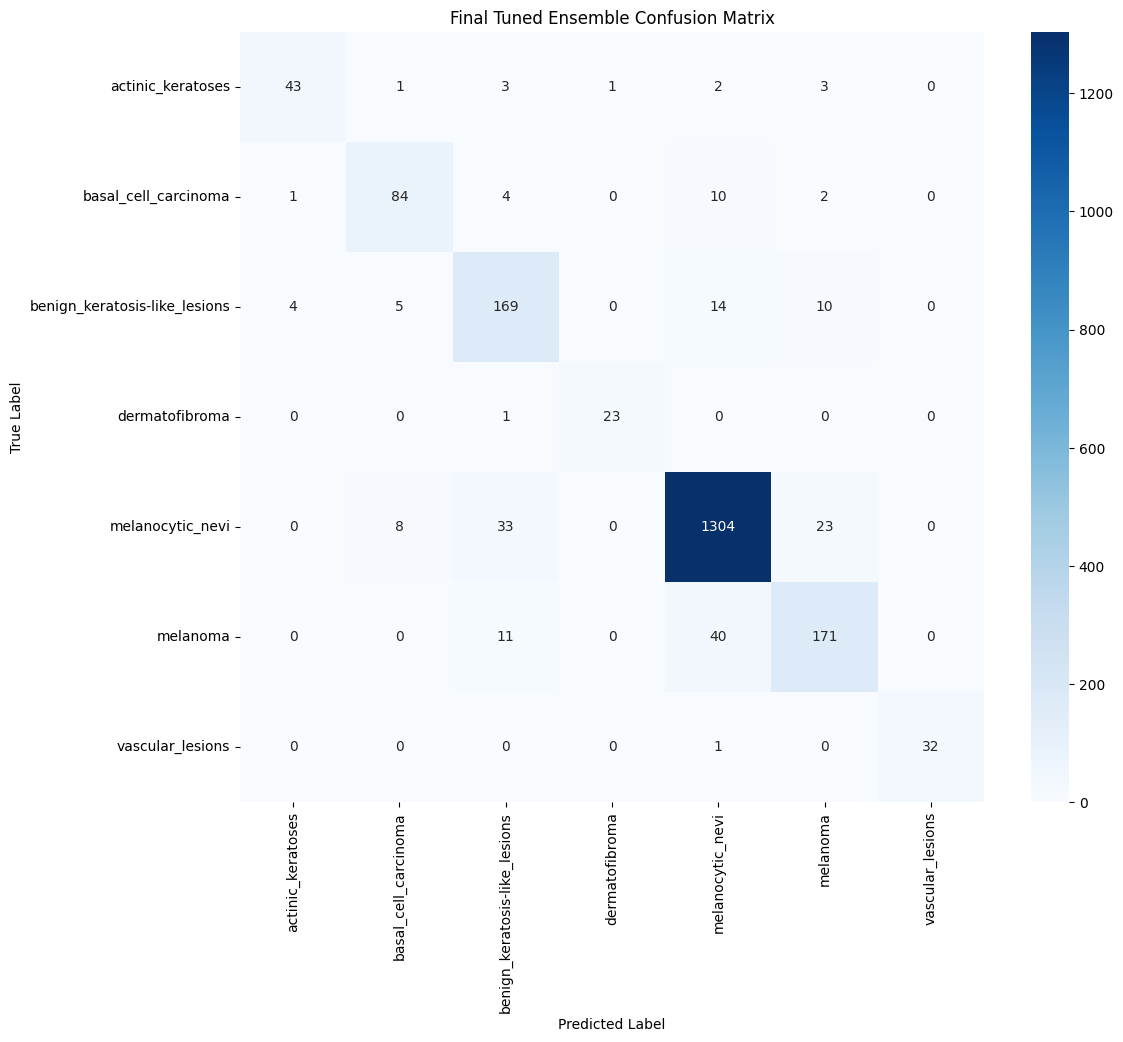


Final Tuned Ensemble Accuracy with TTA: 91.16%


In [ ]:
import torch
import torch.nn as nn
import timm
from torch.utils.data import DataLoader, Subset, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from tqdm.notebook import tqdm

# --- 1. Configuration ---
FINAL_MODEL_NAME = 'seresnext101_32x8d'
NUM_CLASSES = 7
IMG_SIZE = 224
TOTAL_BATCH_SIZE = 32 
output_dir = '/kaggle/working/output_images/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Paths to tuned models
model_a_path = 'best_model_A_tuned.pth'
model_b_path = 'best_model_B_tuned.pth'

# --- 2. Load Validation Dataset ---
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_dataset = ImageFolder(output_dir, transform=val_transforms)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
_, val_indices = random_split(range(len(full_dataset)), [train_size, val_size], generator=torch.Generator().manual_seed(42))
val_dataset = Subset(full_dataset, val_indices.indices)

val_loader = DataLoader(val_dataset, batch_size=TOTAL_BATCH_SIZE, shuffle=False)
class_names = full_dataset.classes
print("Performing final ensemble evaluation on the tuned models.")

# --- 3. Load Both Tuned Models ---
model_a = timm.create_model(FINAL_MODEL_NAME, pretrained=False, num_classes=NUM_CLASSES)
model_a.load_state_dict(torch.load(model_a_path))
model_a.to(device)
model_a.eval()
print(f"Model A ('{model_a_path}') loaded.")

model_b = timm.create_model(FINAL_MODEL_NAME, pretrained=False, num_classes=NUM_CLASSES)
model_b.load_state_dict(torch.load(model_b_path))
model_b.to(device)
model_b.eval()
print(f"Model B ('{model_b_path}') loaded.")

# --- 4. Get Ensemble Predictions (with TTA) ---
all_preds_ensemble_tta = []
all_labels_ensemble = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Final Ensemble TTA Evaluation"):
        images, labels = images.to(device), labels.to(device)
        images_flipped = torch.flip(images, dims=[3])

        # Get probabilities from Model A (with TTA)
        probs_a = F.softmax(model_a(images), dim=1)
        probs_a_flipped = F.softmax(model_a(images_flipped), dim=1)
        avg_probs_a = (probs_a + probs_a_flipped) / 2

        # Get probabilities from Model B (with TTA)
        probs_b = F.softmax(model_b(images), dim=1)
        probs_b_flipped = F.softmax(model_b(images_flipped), dim=1)
        avg_probs_b = (probs_b + probs_b_flipped) / 2
        
        # Average the probabilities from both models
        final_probs = (avg_probs_a + avg_probs_b) / 2
        
        _, predicted = torch.max(final_probs, 1)
        all_preds_ensemble_tta.extend(predicted.cpu().numpy())
        all_labels_ensemble.extend(labels.cpu().numpy())

# --- 5. Display Final Ensemble Metrics ---
print("\n--- Final Tuned Ensemble Performance (with TTA) ---")
print("\nClassification Report:")
print(classification_report(all_labels_ensemble, all_preds_ensemble_tta, target_names=class_names, digits=4))

print("\nConfusion Matrix:")
cm = confusion_matrix(all_labels_ensemble, all_preds_ensemble_tta)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Final Tuned Ensemble Confusion Matrix')
plt.show()

ensemble_accuracy = 100 * np.sum(np.array(all_preds_ensemble_tta) == np.array(all_labels_ensemble)) / len(all_labels_ensemble)
print(f"\nFinal Tuned Ensemble Accuracy with TTA: {ensemble_accuracy:.2f}%")